In [1]:
import pandas as pd
import numpy as np

In [2]:
# download the dataset
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv", "./data/X_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv", "./data/y_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv", "./data/X_test.csv")

X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')

In [ ]:
print(X_train.shape)
print(X_train.columns)
print(y_train.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [ ]:
X_train.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


## **1.Use all features to train any linear model in scikit-learn and try different hyperparameters (ex. different degree, complexity). Show their performances.**

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# One-hot encoding
X_train_preprocessed = pd.get_dummies(X_train, columns=['PERIOD'], prefix='PERIOD')
X_train_preprocessed = pd.get_dummies(X_train_preprocessed, columns=['PTS_TYPE'], prefix='PTS_TYPE')

# Bin DRIBBLES into different ranges
bins = [0, 1, 2, 4, 10, 32]
labels = ['0', '1', '2-4', '5-10', '10+']
X_train_preprocessed['DRIBBLES_binned'] = pd.cut(X_train_preprocessed['DRIBBLES'], bins=bins, labels=labels, right=False)

# One-hot encode the binned DRIBBLES feature
X_train_preprocessed = pd.get_dummies(X_train_preprocessed, columns=['DRIBBLES_binned'], prefix='DRIBBLES')

# Standardize numerical features
features_to_standardize = ['GAME_CLOCK', 'SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']
scaler = StandardScaler()
X_train_preprocessed[features_to_standardize] = scaler.fit_transform(X_train_preprocessed[features_to_standardize])

# Drop unnecessary features
X_train_preprocessed = X_train_preprocessed.drop(['DRIBBLES'], axis=1)

# Split training and validation sets
y_train_orig = y_train
X_train_split, X_val_split, y_train_orig, y_val_orig = train_test_split(X_train_preprocessed, y_train_orig, test_size=0.05, random_state=25)
y_train_orig = y_train_orig.values.ravel()
y_val_orig = y_val_orig.values.ravel()

# Select features for polynomial expansion (only numerical features)
features_for_poly = X_train_split[features_to_standardize].columns.tolist()
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply polynomial expansion to numerical features
features_for_poly = ['GAME_CLOCK', 'SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']
X_train_poly = poly.fit_transform(X_train_split[features_for_poly])
X_val_poly = poly.transform(X_val_split[features_for_poly])

# Get the names of the polynomial features
poly_feature_names = poly.get_feature_names_out(features_for_poly)

# Create DataFrame and merge
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly_feature_names)

# Combine one-hot encoded features with polynomial features
X_train_preprocessed = pd.concat([X_train_poly_df, X_train_split.drop(features_for_poly, axis=1).reset_index(drop=True)], axis=1)
X_val_preprocessed = pd.concat([X_val_poly_df, X_val_split.drop(features_for_poly, axis=1).reset_index(drop=True)], axis=1)

# Now X_train_final and X_val_final are the preprocessed feature sets

In [ ]:
X_train_preprocessed.head()

,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,GAME_CLOCK^2,GAME_CLOCK SHOT_CLOCK,GAME_CLOCK TOUCH_TIME,GAME_CLOCK SHOT_DIST,GAME_CLOCK CLOSE_DEF_DIST,...,PERIOD_5,PERIOD_6,PERIOD_7,PTS_TYPE_2,PTS_TYPE_3,DRIBBLES_0,DRIBBLES_1,DRIBBLES_2-4,DRIBBLES_5-10,DRIBBLES_10+
0,-0.656012,-1.817922,-0.083071,0.122241,-0.989966,0.430351,1.192578,0.054496,-0.080191,0.649429,...,False,False,False,True,False,False,True,False,False,False
1,0.833071,1.486157,-0.420297,-1.142979,1.232657,0.694007,1.238074,-0.350137,-0.952183,1.026891,...,False,False,False,True,False,False,True,False,False,False
2,0.758864,-0.809308,-0.656355,1.239282,0.831856,0.575874,-0.614155,-0.498084,0.940446,0.631266,...,False,False,False,False,True,True,False,False,False,False
3,0.897383,1.364428,-0.487742,1.239282,-0.261237,0.805297,1.224414,-0.437691,1.112111,-0.234430,...,False,False,False,False,True,True,False,False,False,False
4,0.184998,0.512323,-0.588910,-0.675646,-0.334110,0.034224,0.094779,-0.108947,-0.124993,-0.061810,...,False,False,False,True,False,True,False,False,False,False


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create a logistic regression model, using L1 regularization
logisticRegression_model = LogisticRegression(max_iter=100, C=1000, penalty='l1', solver='liblinear')

# Fit the model on the entire training set
logisticRegression_model.fit(X_train_preprocessed, y_train_orig)

# Use the trained model to make predictions
y_pred_train = logisticRegression_model.predict(X_train_preprocessed)
y_pred_val = logisticRegression_model.predict(X_val_preprocessed)

# Calculate the accuracy of the training set and validation set
accuracy_train = accuracy_score(y_train_orig, y_pred_train)
print(f"Training accuracy: {accuracy_train:.2f}")
accuracy_val = accuracy_score(y_val_orig, y_pred_val)
print(f"Validation accuracy: {accuracy_val:.2f}")

# Output confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_val_orig, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val_orig, y_pred_val))


Training accuracy: 0.61
Validation accuracy: 0.62
Confusion Matrix:
[[1900  510]
 [1108  770]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      2410
           1       0.60      0.41      0.49      1878

    accuracy                           0.62      4288
   macro avg       0.62      0.60      0.59      4288
weighted avg       0.62      0.62      0.61      4288



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifier

# Create a Ridge classifier
RidgeClassifier_model = RidgeClassifier(alpha=1.0)  # alpha is the regularization parameter

# Fit the model on the entire training set
RidgeClassifier_model.fit(X_train_preprocessed, y_train_orig)

# Use the trained model to make predictions
y_pred_train = RidgeClassifier_model.predict(X_train_preprocessed)
y_pred_val = RidgeClassifier_model.predict(X_val_preprocessed)

# Calculate the accuracy of the training set and validation set
accuracy_train = accuracy_score(y_train_orig, y_pred_train)
print(f"Training accuracy: {accuracy_train:.2f}")
accuracy_val = accuracy_score(y_val_orig, y_pred_val)
print(f"Validation accuracy: {accuracy_val:.2f}")

# Output confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_val_orig, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val_orig, y_pred_val))


Training accuracy: 0.61
Validation accuracy: 0.62
Confusion Matrix:
[[1905  505]
 [1108  770]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      2410
           1       0.60      0.41      0.49      1878

    accuracy                           0.62      4288
   macro avg       0.62      0.60      0.60      4288
weighted avg       0.62      0.62      0.61      4288



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier

# Create a stochastic gradient descent classifier
SGDClassifier_model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)  # 使用逻辑损失函数

# Fit the model on the entire training set
SGDClassifier_model.fit(X_train_preprocessed, y_train_orig)

# Use the trained model to make predictions
y_pred_train = SGDClassifier_model.predict(X_train_preprocessed)
y_pred_val = SGDClassifier_model.predict(X_val_preprocessed)

# Calculate the accuracy of the training set and validation set
accuracy_train = accuracy_score(y_train_orig, y_pred_train)
print(f"Training accuracy: {accuracy_train:.2f}")
accuracy_val = accuracy_score(y_val_orig, y_pred_val)
print(f"Validation accuracy: {accuracy_val:.2f}")

# Output confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_val_orig, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val_orig, y_pred_val))


Training accuracy: 0.60
Validation accuracy: 0.59
Confusion Matrix:
[[1779  631]
 [1118  760]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2410
           1       0.55      0.40      0.46      1878

    accuracy                           0.59      4288
   macro avg       0.58      0.57      0.57      4288
weighted avg       0.58      0.59      0.58      4288



## **2.Select 1 setting (model + hyperparameters) and plot the error curve to show that the setting you selected isn't over-fit.**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

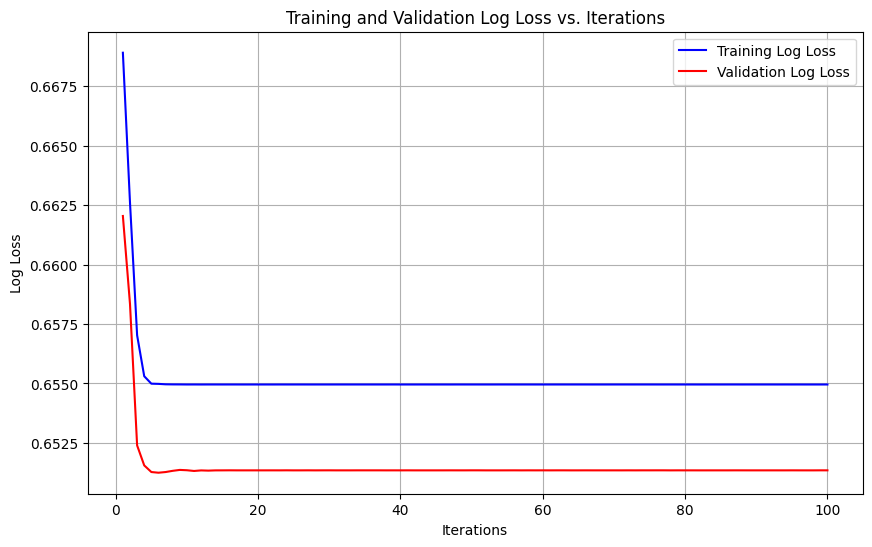

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Set the basic parameters of the model
logisticRegression_model = LogisticRegression(max_iter=1, C=1000, penalty='l1', solver='liblinear', warm_start=True)

train_losses = []
val_losses = []

# Conduct multiple iterations of training and record the log loss each time
max_iterations = 100
for i in range(1, max_iterations + 1):
    logisticRegression_model.max_iter = i
    logisticRegression_model.fit(X_train_preprocessed, y_train_orig)

    # Training set log loss
    y_pred_train_proba = logisticRegression_model.predict_proba(X_train_preprocessed)
    loss_train = log_loss(y_train_orig, y_pred_train_proba)
    train_losses.append(loss_train)

    # Validation set log loss
    y_pred_val_proba = logisticRegression_model.predict_proba(X_val_preprocessed)
    loss_val = log_loss(y_val_orig, y_pred_val_proba)
    val_losses.append(loss_val)

# Plot error curve (log loss)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, max_iterations + 1), train_losses, label='Training Log Loss', color='blue')
plt.plot(np.arange(1, max_iterations + 1), val_losses, label='Validation Log Loss', color='red')
plt.title('Training and Validation Log Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()


# **3.Use any method to choose the best 3 features that can best aid the model's prediction. Explain how you find it.**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
#Recursive Feature Elimination (RFE) is a feature selection method that works by recursively removing the least important features and building a model with the remaining ones.
#The goal of RFE is to select a subset of features that produces the best-performing model by systematically eliminating those that are least useful. It helps in reducing overfitting, improving model performance, and decreasing computational cost, especially when dealing with high-dimensional data.

# Create a logistic regression model
logisticRegression_model = LogisticRegression(max_iter=100, C=1000, penalty='l1', solver='liblinear')

# Recursive feature elimination, select the 3 best features
rfe = RFE(estimator=logisticRegression_model, n_features_to_select=10)
rfe.fit(X_train_preprocessed, y_train_orig)

# Print selected features
selected_features = X_train_preprocessed.columns[rfe.support_]
print("Selected best 10 features:", selected_features)

#Listing the top ten most influential features and excluding feature combinations, we can find that the top three are SHOT_DIST', 'CLOSE_DEF_DIST' and 'PERIOD'


Selected best 10 features: Index(['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_DIST^2',
       'SHOT_DIST CLOSE_DEF_DIST', 'PERIOD_5', 'PERIOD_7', 'PTS_TYPE_2',
       'DRIBBLES_0', 'DRIBBLES_1', 'DRIBBLES_2-4'],
      dtype='object')


# **4.Train the model selected in 2. with the only 3 features selected in 3., and present the training error.**

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

X_train_top_3 = X_train.drop(['GAME_CLOCK',	'SHOT_CLOCK',	'DRIBBLES',	'TOUCH_TIME',	'PTS_TYPE'], axis=1)

# One-hot encoding
X_train_top_3 = pd.get_dummies(X_train_top_3, columns=['PERIOD'], prefix='PERIOD')

# Standardize numerical features
features_to_standardize = ['SHOT_DIST', 'CLOSE_DEF_DIST']
scaler = StandardScaler()
X_train_top_3[features_to_standardize] = scaler.fit_transform(X_train_top_3[features_to_standardize])

# Split training and validation sets
y_train_top_3 = y_train
X_train_top_3_split, X_val_top_3_split, y_train_top_3, y_val_top_3 = train_test_split(X_train_top_3, y_train_top_3, test_size=0.05, random_state=25)
y_train_top_3 = y_train_top_3.values.ravel()
y_val_top_3 = y_val_top_3.values.ravel()

# Select features for polynomial expansion (only numerical features)
features_for_poly = ['SHOT_DIST', 'CLOSE_DEF_DIST']
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply polynomial expansion to numerical features
X_train_top_3_poly = poly.fit_transform(X_train_top_3_split[features_for_poly])
X_val_top_3_poly = poly.transform(X_val_top_3_split[features_for_poly])

# Get the names of the polynomial features
poly_feature_names = poly.get_feature_names_out(features_for_poly)

# Create DataFrame and merge
X_train_poly_df = pd.DataFrame(X_train_top_3_poly, columns=poly_feature_names)
X_val_poly_df = pd.DataFrame(X_val_top_3_poly, columns=poly_feature_names)

# Combine one-hot encoded features with polynomial features
X_train_top_3_preprocessed = pd.concat([X_train_poly_df, X_train_top_3_split.drop(features_for_poly, axis=1).reset_index(drop=True)], axis=1)
X_val_top_3_preprocessed = pd.concat([X_val_poly_df, X_val_top_3_split.drop(features_for_poly, axis=1).reset_index(drop=True)], axis=1)

# Create a logistic regression model, using L1 regularization
logisticRegression_top_3_model = LogisticRegression(max_iter=100, C=1000, penalty='l1', solver='liblinear')

# Fit the model on the entire training set
logisticRegression_top_3_model.fit(X_train_top_3_preprocessed, y_train_top_3)

# Use the trained model to make predictions (both class labels and probabilities)
y_pred_top_3_train = logisticRegression_top_3_model.predict(X_train_top_3_preprocessed)
y_pred_top_3_val = logisticRegression_top_3_model.predict(X_val_top_3_preprocessed)

# Predict probabilities for log loss calculation
y_pred_train_proba = logisticRegression_top_3_model.predict_proba(X_train_top_3_preprocessed)
y_pred_val_proba = logisticRegression_top_3_model.predict_proba(X_val_top_3_preprocessed)

# Calculate the accuracy of the training set and validation set
accuracy_top_3_train = accuracy_score(y_train_top_3, y_pred_top_3_train)
accuracy_top_3_val = accuracy_score(y_val_top_3, y_pred_top_3_val)

# Calculate the log loss for training and validation sets
log_loss_train = log_loss(y_train_top_3, y_pred_train_proba)
log_loss_val = log_loss(y_val_top_3, y_pred_val_proba)

# Calculate accuracy-based training error
training_error_accuracy_based = 1 - accuracy_top_3_train

# Print the accuracies, log losses, and training errors
print(f"Training accuracy: {accuracy_top_3_train:.2f}")
print(f"Validation accuracy: {accuracy_top_3_val:.2f}")
print(f"Training log loss: {log_loss_train:.4f}")
print(f"Validation log loss: {log_loss_val:.4f}")
print(f"Training error (accuracy-based): {training_error_accuracy_based:.2f}")

# Output confusion matrix and classification report for validation set
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_top_3, y_pred_top_3_val))
print("\nClassification Report:")
print(classification_report(y_val_top_3, y_pred_top_3_val))


Training accuracy: 0.61
Validation accuracy: 0.62
Training log loss: 0.6574
Validation log loss: 0.6550
Training error (accuracy-based): 0.39

Confusion Matrix:
[[1881  529]
 [1113  765]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2410
           1       0.59      0.41      0.48      1878

    accuracy                           0.62      4288
   macro avg       0.61      0.59      0.59      4288
weighted avg       0.61      0.62      0.60      4288



In [10]:
X_train_top_3_preprocessed.head()

,SHOT_DIST,CLOSE_DEF_DIST,SHOT_DIST^2,SHOT_DIST CLOSE_DEF_DIST,CLOSE_DEF_DIST^2,PERIOD_1,PERIOD_2,PERIOD_3,PERIOD_4,PERIOD_5,PERIOD_6,PERIOD_7
0,0.122241,-0.989966,0.014943,-0.121014,0.980033,False,True,False,False,False,False,False
1,-1.142979,1.232657,1.306402,-1.408902,1.519444,False,False,True,False,False,False,False
2,1.239282,0.831856,1.535819,1.030904,0.691985,False,False,False,True,False,False,False
3,1.239282,-0.261237,1.535819,-0.323746,0.068245,False,False,True,False,False,False,False
4,-0.675646,-0.334110,0.456497,0.225740,0.111630,False,False,False,True,False,False,False


# **5.Export the predictions of the model trained in 4. for X_test (follow the format of y_train.csv).**

In [ ]:
X_test_top_3 = X_test.drop(['GAME_CLOCK',	'SHOT_CLOCK',	'DRIBBLES',	'TOUCH_TIME',	'PTS_TYPE'], axis=1)

# One-hot encoding
X_test_top_3 = pd.get_dummies(X_test_top_3, columns=['PERIOD'], prefix='PERIOD')

# Standardize numerical features
features_to_standardize = ['SHOT_DIST', 'CLOSE_DEF_DIST']
scaler = StandardScaler()
X_test_top_3[features_to_standardize] = scaler.fit_transform(X_test_top_3[features_to_standardize])

# Select features for polynomial expansion (only numerical features)
features_for_poly = ['SHOT_DIST', 'CLOSE_DEF_DIST']
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply polynomial expansion to numerical features
X_test_top_3_poly = poly.fit_transform(X_test_top_3[features_for_poly])

# Get the names of the polynomial features
poly_feature_names = poly.get_feature_names_out(features_for_poly)

# Create DataFrame and merge
X_test_poly_df = pd.DataFrame(X_test_top_3_poly, columns=poly_feature_names)

# Combine one-hot encoded features with polynomial features
X_test_top_3_preprocessed = pd.concat([X_test_poly_df, X_test_top_3.drop(features_for_poly, axis=1).reset_index(drop=True)], axis=1)

# Use the trained model to make predictions
y_pred_top_3_test = logisticRegression_top_3_model.predict(X_test_top_3_preprocessed)
df = pd.DataFrame(y_pred_top_3_test, columns=['FGM'])
df.to_csv('./data/Lab05_113062624_y_pred.csv', index=False)


# **A brief report of what you have done in this assignment.**

# **Code implementation:**

1.First preprocesses data for a machine learning model. It first applies one-hot encoding to categorical features like `PERIOD` and `PTS_TYPE`. Next, it bins the `DRIBBLES` feature into specified ranges, then one-hot encodes these binned categories. After that, numerical features such as `GAME_CLOCK`, `SHOT_CLOCK`, and `TOUCH_TIME` are standardized using `StandardScaler` to ensure they have a mean of zero and a standard deviation of one. The original `DRIBBLES` feature is then dropped, and the dataset is split into training and validation sets with a 95%-5% split.

2.After processing data, now trains a logistic regression model over multiple iterations and tracks the accuracy on both the training and validation sets at each step. The model uses `L1` regularization (`penalty='l1'`), the `liblinear` solver, and `warm_start=True` to retain the learned coefficients across iterations. The training is conducted for up to 100 iterations, where after each iteration, the accuracy of the model is calculated for both the training and validation sets. These accuracy values are stored in separate lists (`train_accuracies` and `val_accuracies`), which are then plotted against the number of iterations to visualize the model's performance over time. It can be seen that the performance of the training set and the verification set tend to be close, and there is no overfit problem.

3.The relevant details and principles of RFE have been explained above.

4.Perform the same preprocessing action after selecting features, and choose to train with the LogisticRegression model.

5.Perform the same data preprocessing as 4., and output the prediction results to a csv file.


---



# **Analysis:**
In the data preprocessing part, I chose to perform one hot encoding on PERIOD and PTS_TYPE because there are not many types of data and the characteristic properties are not numerically sequential.As for the DRIBBLE data, I chose to do binning processing because I observed that the data was unevenly distributed. There were a large number of dribbling numbers at 0 or 1, while those above 10 were extremely sparse and formed a group of their own.

In terms of model accuracy, the best situation is only 60%, but I think this value is reasonable. Because there are too many factors that affect goals, it is difficult to accurately estimate goals from the original 8 features.After filtering the features, it can be found that the accuracy rate has almost not changed, which is also within my expectation, because I used L1 regularization in the original model, which will automatically eliminate unimportant features, so the accuracy rate is similar.